# Dog Vs Cat Classification Using Deep Learning
In this notebook, we will make a classification model to classify the images of dogs and cats using following techniques:
* Convolutional Neural Netwowk (CNN)
* CNN with Varied Layers
* Transfer Learning

In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet152
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
!nvidia-smi

Wed Mar  9 06:32:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [ ]:
# define root directory
root_dir = '/tmp/cats-v-dogs'

# empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
  train_dir = os.path.join(root_dir, 'training')
  test_dir = os.path.join(root_dir, 'testing')
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')
  test_cats_dir = os.path.join(test_dir, 'cats')
  test_dogs_dir = os.path.join(test_dir, 'dogs')

  os.makedirs(train_dir)
  os.makedirs(test_dir)
  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)
  os.makedirs(test_cats_dir)
  os.makedirs(test_dogs_dir)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


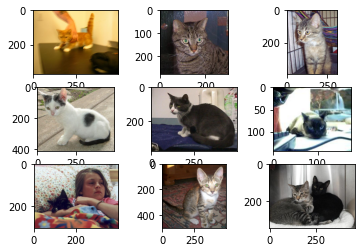

In [ ]:
# show some images of cats
folder = '/tmp/cats-v-dogs/training/cats/'
for i in range(9):
  plt.subplot(330 + i + 1)
  file = folder + str(i) + '.jpg'
  image = imread(file)
  plt.imshow(image)

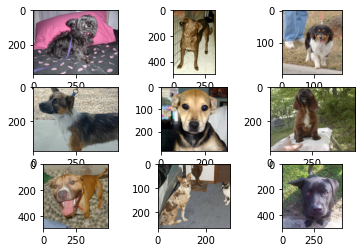

In [ ]:
# show some images of dogs
folder = '/tmp/cats-v-dogs/training/dogs/'
for i in range(9):
  plt.subplot(330 + i + 1)
  file = folder + str(i) + '.jpg'
  image = imread(file)
  plt.imshow(image)

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  dataset = []
  for u_data in os.listdir(SOURCE):
    data = SOURCE + u_data
    if os.path.getsize(data) > 0:
      dataset.append(u_data)
    else:
      print(u_data + ' is zero length, so ignoring')

  train_set_length = int(len(dataset) * SPLIT_SIZE)
  test_set_length = int(len(dataset) - (train_set_length))
  shuffle = random.sample(dataset, len(dataset))
  train_set = dataset[0: train_set_length]
  test_set = dataset[-test_set_length:]

  for u_data in train_set:
    temp_train = SOURCE + u_data
    final_train = TRAINING + u_data
    copyfile(temp_train, final_train)

  for u_data in test_set:
    temp_test = SOURCE + u_data
    final_test = TESTING + u_data
    copyfile(temp_test, final_test)

In [ ]:
# define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# define proportion of images used for training
split_size = 0.9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# checking that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


## Using ImageDataGenerator for Data Augmentation

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1/255.0)

  validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=128,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [ ]:
# testing generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 1. Using Convolutional Neural Network (CNN) for Training

In [ ]:
# create deep learning model
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  return model

In [ ]:
# call the model function
model = create_model()

import warnings
warnings.filterwarnings('ignore')

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
176/176 [==============================] - 176s 938ms/step - loss: 0.6702 - accuracy: 0.6028 - val_loss: 0.5864 - val_accuracy: 0.6908
Epoch 2/15
176/176 [==============================] - 159s 903ms/step - loss: 0.5931 - accuracy: 0.6808 - val_loss: 0.5134 - val_accuracy: 0.7452
Epoch 3/15
176/176 [==============================] - 159s 901ms/step - loss: 0.5607 - accuracy: 0.7106 - val_loss: 0.5124 - val_accuracy: 0.7416
Epoch 4/15
176/176 [==============================] - 158s 900ms/step - loss: 0.5376 - accuracy: 0.7251 - val_loss: 0.4986 - val_accuracy: 0.7508
Epoch 5/15
176/176 [==============================] - 158s 900ms/step - loss: 0.5216 - accuracy: 0.7362 - val_loss: 0.4740 - val_accuracy: 0.7760
Epoch 6/15
176/176 [==============================] - 158s 900ms/step - loss: 0.5045 - accuracy: 0.7527 - val_loss: 0.4554 - val_accuracy: 0.7908
Epoch 7/15
176/176 [==============================] - 160s 908ms/step - loss: 0.4956 - accuracy: 0.7570 - val_loss: 0.4517 -

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

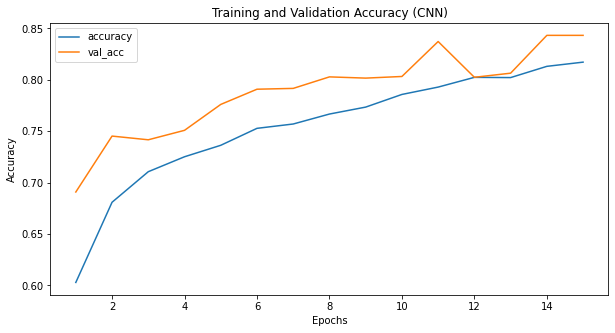

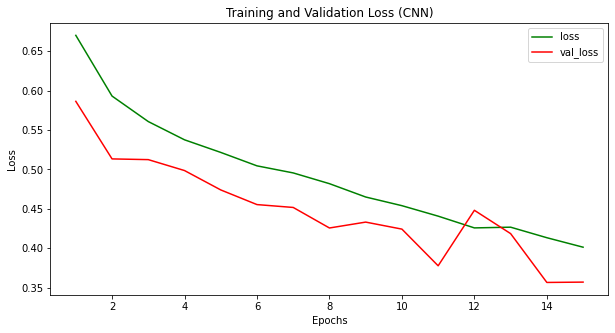

In [ ]:
history = history

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# accuracy/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# loss/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Using Support Vector Machine (SVM) for Training

In [ ]:
from keras.regularizers import l2

In [ ]:
def create_model_svm():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01), activation = "linear")])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.Hinge(),
                metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
svm = create_model_svm()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
history_svm = svm.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
176/176 [==============================] - 166s 945ms/step - loss: 0.6223 - accuracy: 0.7026 - val_loss: 0.6185 - val_accuracy: 0.7664
Epoch 2/15
176/176 [==============================] - 163s 924ms/step - loss: 0.5938 - accuracy: 0.7182 - val_loss: 0.5551 - val_accuracy: 0.7780
Epoch 3/15
176/176 [==============================] - 160s 911ms/step - loss: 0.5663 - accuracy: 0.7334 - val_loss: 0.4977 - val_accuracy: 0.7928
Epoch 4/15
176/176 [==============================] - 160s 908ms/step - loss: 0.5581 - accuracy: 0.7364 - val_loss: 0.4778 - val_accuracy: 0.8052
Epoch 5/15
176/176 [==============================] - 159s 903ms/step - loss: 0.5403 - accuracy: 0.7466 - val_loss: 0.4180 - val_accuracy: 0.8136
Epoch 6/15
176/176 [==============================] - 159s 901ms/step - loss: 0.5218 - accuracy: 0.7526 - val_loss: 0.4211 - val_accuracy: 0.8100
Epoch 7/15
176/176 [==============================] - 163s 927ms/step - loss: 0.5051 - accuracy: 0.7623 - val_loss: 0.4021 -

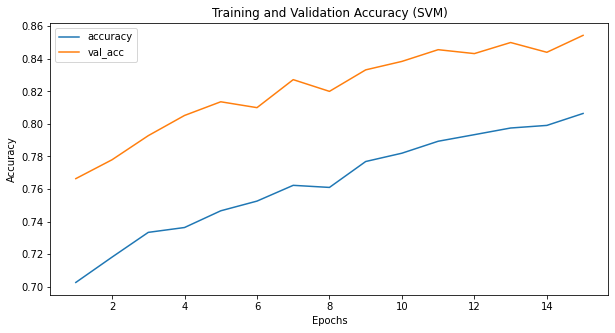

In [ ]:
history = history_svm.history

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# accuracy/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (SVM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# loss/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss (SVM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
# make predictions and confusion matrix
y_pred_svm = svm.predict(validation_generator)
y_hat_svm = np.argmax(y_pred_svm, axis = 1)
# confusion_matrix(np.argmax(validation_generator, axis = 1), y_hat_svm)

## 3. Transfer Learning
Now, we will attempt to use a pre-trained Inception V3 Network on our data

In [ ]:
def create_pre_trained_model():
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = 'imagenet')

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model



In [ ]:
pre_trained_model = create_pre_trained_model()

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
def create_final_model(pre_trained_model, last_output):
  # flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(last_output)

  # adding a fully connected layer with 1024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
  # adding a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)
  # adding a final sigmoid layer for classification
  x = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

  # create the complete model by using the Model class
  model = keras.models.Model(inputs=pre_trained_model.input, outputs=x)

  # compile the model
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
model_inception = create_final_model(pre_trained_model, last_output)
model_inception

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model_inception.h5', monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

In [ ]:
history_inception = model_inception.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 15,
                    verbose = 1,
                    callbacks=checkpoint)

Epoch 1/15
 39/176 [=====>........................] - ETA: 2:00 - loss: 0.1001 - accuracy: 0.9613

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

176/176 [==============================] - 161s 916ms/step - loss: 0.0934 - accuracy: 0.9623 - val_loss: 0.0616 - val_accuracy: 0.9788
Epoch 2/15
176/176 [==============================] - 162s 918ms/step - loss: 0.0907 - accuracy: 0.9630 - val_loss: 0.0598 - val_accuracy: 0.9788
Epoch 3/15
176/176 [==============================] - 161s 916ms/step - loss: 0.0878 - accuracy: 0.9636 - val_loss: 0.0564 - val_accuracy: 0.9788
Epoch 4/15
176/176 [==============================] - 162s 919ms/step - loss: 0.0859 - accuracy: 0.9656 - val_loss: 0.0600 - val_accuracy: 0.9752
Epoch 5/15
176/176 [==============================] - 161s 916ms/step - loss: 0.0835 - accuracy: 0.9662 - val_loss: 0.0595 - val_accuracy: 0.9756
Epoch 6/15
176/176 [==============================] - 161s 917ms/step - loss: 0.0864 - accuracy: 0.9654 - val_loss: 0.0585 - val_accuracy: 0.9772
Epoch 7/15
176/176 [==============================] - 162s 918ms/step - loss: 0.0832 - accuracy: 0.9664 - val_loss: 0.0567 - val_accura

In [ ]:
history_inception

### Visualize Results of Transfer Learning with InceptionV3

In [ ]:
history = history_inception.history

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# accuracy/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# loss/epoch plot
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [ ]:
# evaluate model score with inception
_, acc = model_inception.evaluate(validation_generator, verbose=1)
print('> %.3f' % (acc * 100.0))

20/20 [==============================] - 7s 354ms/step - loss: 0.0572 - accuracy: 0.9784
> 97.840


In [ ]:
y_pred_inception = model_inception.predict(validation_generator)
y_hat_inception = np.argmax(y_pred_inception, axis=1)

In [ ]:
# print classification report
print(classification_report(validation_generator.classes, y_hat_inception))